<center/>
<h1>RNN, LSTM, GRU</h1>
<h9>Amir Mohammad Fakhimi</h9>

## Using prepared APIs of RNN, LSTM, GRU

In [2]:
import torch
import torch.nn as nn

In [3]:
batch_size = 4
seq_len = 5
input_size = 3
hidden_size = 6
num_layers = 1

In [4]:
# Synthetic input: (batch, seq, features)
# Using batch_first=True so dims = (B, T, F)
x = torch.randn(batch_size, seq_len, input_size)

In [5]:
rnn_layer = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
lstm_layer = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
gru_layer = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

In [8]:
h0_rnn = torch.zeros(num_layers, batch_size, hidden_size)
h0_gru = torch.zeros(num_layers, batch_size, hidden_size)

h0_lstm = torch.zeros(num_layers, batch_size, hidden_size)
c0_lstm = torch.zeros(num_layers, batch_size, hidden_size)

In [9]:
out_rnn, hn_rnn = rnn_layer(x, h0_rnn)

print('RNN output shape:', out_rnn.shape)  # (B, T, H)
print('RNN final hidden:', hn_rnn.shape)  # (num_layers, B, H)

RNN output shape: torch.Size([4, 5, 6])
RNN final hidden: torch.Size([1, 4, 6])


In [13]:
# PyTorch automatically initialize h and c to zero tensors if not provided
out_rnn, hn_rnn = rnn_layer(x)

print('RNN output shape:', out_rnn.shape)  # (B, T, H)
print('RNN final hidden:', hn_rnn.shape)  # (num_layers, B, H)

RNN output shape: torch.Size([4, 5, 6])
RNN final hidden: torch.Size([1, 4, 6])


In [10]:
out_lstm, (hn_lstm, cn_lstm) = lstm_layer(x, (h0_lstm, c0_lstm))

print('LSTM output shape:', out_lstm.shape)  # (B, T, H)
print('LSTM final hidden:', hn_lstm.shape)  # (num_layers, B, H)
print('LSTM final cell state:', cn_lstm.shape)  # (num_layers, B, H)

LSTM output shape: torch.Size([4, 5, 6])
LSTM final hidden: torch.Size([1, 4, 6])
LSTM final cell state: torch.Size([1, 4, 6])


In [11]:
out_gru, hn_gru = gru_layer(x, h0_gru)

print('GRU output shape:', out_gru.shape)  # (B, T, H)
print('GRU final hidden:', hn_gru.shape)  # (num_layers, B, H)

GRU output shape: torch.Size([4, 5, 6])
GRU final hidden: torch.Size([1, 4, 6])


## Training an LSTM on Time-Series Data

In [163]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [164]:
SEED = 42

torch.manual_seed(SEED)

In [165]:
# Annual sunspot counts (1700–2008)
ds = sm.datasets.sunspots.load_pandas().data
series = ds['SUNACTIVITY'].values.astype(np.float32)

In [166]:
series.shape, series[0]

((309,), 5.0)

In [167]:
# Normalize
mean, std = series.mean(), series.std()
series = (series - mean) / std

In [168]:
# Creating windows of data
def create_windows(data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i: i + look_back])
        y.append(data[i + look_back])

    return np.array(X), np.array(y)

In [169]:
look_back = 10
X_np, y_np = create_windows(series, look_back)

In [170]:
X_np.shape, y_np.shape

((299, 10), (299,))

In [171]:
# Wrap in PyTorch tensors & DataLoader
X = torch.from_numpy(X_np).unsqueeze(-1)  # (N, T, 1)
y = torch.from_numpy(y_np)  # (N,)

In [172]:
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [173]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (B, T, 1)
        out, (h_n, _) = self.lstm(x)  # out: (B, T, H)
        last_h = h_n[-1]  # (B, H)
        return self.fc(last_h).squeeze(-1)  # (B,)

In [174]:
model = LSTMRegressor()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [175]:
epochs = 20
history = []

model.train()
for ep in range(epochs):
    total_loss = 0
    for xb, yb in loader:
        pred = model(xb)

        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

    avg = total_loss / len(dataset)
    history.append(avg)

    print(f'Epoch {ep + 1:02d}/{epochs} — Loss: {avg:.4f}')

Epoch 01/20 — Loss: 0.9906
Epoch 02/20 — Loss: 0.9328
Epoch 03/20 — Loss: 0.8759
Epoch 04/20 — Loss: 0.8003
Epoch 05/20 — Loss: 0.6949
Epoch 06/20 — Loss: 0.5020
Epoch 07/20 — Loss: 0.3105
Epoch 08/20 — Loss: 0.2353
Epoch 09/20 — Loss: 0.2016
Epoch 10/20 — Loss: 0.1872
Epoch 11/20 — Loss: 0.1771
Epoch 12/20 — Loss: 0.1665
Epoch 13/20 — Loss: 0.1571
Epoch 14/20 — Loss: 0.1480
Epoch 15/20 — Loss: 0.1417
Epoch 16/20 — Loss: 0.1405
Epoch 17/20 — Loss: 0.1329
Epoch 18/20 — Loss: 0.1300
Epoch 19/20 — Loss: 0.1266
Epoch 20/20 — Loss: 0.1256


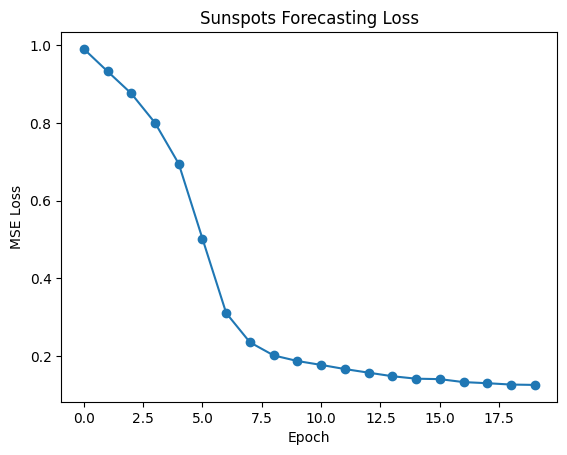

In [176]:
plt.plot(history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Sunspots Forecasting Loss')
plt.show()

In [177]:
model.eval()

with torch.no_grad():
    last_win = torch.from_numpy(series[-look_back:]).unsqueeze(0).unsqueeze(-1)  # (1, T, 1)
    pred_norm = model(last_win).item()
    pred = pred_norm * std + mean

    print(f'Predicted sunspots in 2009: {pred:.1f}')

Predicted sunspots in 2009: 29.1


## Sentiment Analysis Using LSTM

In [213]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from collections import Counter
from itertools import chain
from tqdm.notebook import tqdm

In [200]:
# Load SST-2 from the GLUE benchmark
# https://huggingface.co/datasets/nyu-mll/glue#sst2
ds = load_dataset('glue', 'sst2')
train_ds = ds['train']
valid_ds = ds['validation']

In [201]:
def tokenize(text):
    return text.lower().split()

In [ ]:
counter = Counter(chain.from_iterable(tokenize(example['sentence']) for example in train_ds))
counter

We cap the vocab at the top 10 000 tokens for three main practical reasons:
- **Memory & Speed:** Every token in your vocabulary needs its own embedding vector (and potentially gradients) in memory.
- **Noise Reduction:** Very infrequent words often contribute little signal but can introduce noise (typos, named entities, obscure terms). By grouping all of those into a single `<UNK>` token, the model focuses its capacity on learning representations for words it actually sees often.
- **Generalization:** A smaller vocab encourages the model to learn broader patterns (e.g. how common words combine).

In [203]:
# keep only the top 10 000 words
most_common = [w for w, _ in counter.most_common(10_000)]

# reserve 0 for PAD, 1 for UNK (Why UNK is needed?)
vocab = {w: i + 2 for i, w in enumerate(most_common)}
PAD, UNK = 0, 1

In [204]:
def encode(text):
    return [vocab.get(tok, UNK) for tok in tokenize(text)]

The lengths tensor holds the true length of each sequence in the batch before padding. We need it whenever we work with variable-length sequences so that our LSTM only processes the real tokens and ignores the padding.

`padded` is (B, T, H) tensor after embedding and padding. `lengths` tells PyTorch how many timesteps in each sequence are actual data vs. padding.

In [205]:
# Collate function: pads to max-length in batch
def collate_batch(batch):
    # batch: list of dicts with 'sentence' and 'label'
    seqs, labels = [], []
    for example in batch:
        token_ids = torch.tensor(encode(example['sentence']), dtype=torch.long)
        seqs.append(token_ids)
        labels.append(example['label'])

    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    # pad
    padded = nn.utils.rnn.pad_sequence(seqs, batch_first=True, padding_value=PAD)

    return padded, lengths, torch.tensor(labels, dtype=torch.long)

In [206]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_ds, batch_size, shuffle=False, collate_fn=collate_batch)

In [207]:
# Model: Embedding -> LSTM -> Classifier
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x, lengths):
        emb = self.embed(x)  # (B, T, E)
        # pack for efficiency
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)
        last_h = h_n[-1]  # (B, H)
        return self.fc(last_h)

In [208]:
device = torch.device('mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
model = SentimentLSTM(vocab_size=len(vocab) + 2).to(device)

In [209]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 3

In [212]:
progress_bar = tqdm(range(1, num_epochs + 1))
for epoch in progress_bar:
    model.train()
    train_correct = train_total = 0

    for xb, lengths, yb in train_loader:
        xb, lengths, yb = xb.to(device), lengths.to(device), yb.to(device)

        optimizer.zero_grad()

        logits = model(xb, lengths)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=1)
        train_correct += (preds == yb).sum().item()
        train_total += yb.size(0)

    acc = train_correct / train_total
    print(f'Epoch {epoch}/{num_epochs} — Train Acc: {acc:.4f}')

Epoch 1/3 — Train Acc: 0.7659
Epoch 2/3 — Train Acc: 0.8938
Epoch 3/3 — Train Acc: 0.9289


In [214]:
model.eval()
val_correct = val_total = 0

with torch.no_grad():
    for xb, lengths, yb in valid_loader:
        xb, lengths, yb = xb.to(device), lengths.to(device), yb.to(device)

        logits = model(xb, lengths)
        preds = logits.argmax(dim=1)
        val_correct += (preds == yb).sum().item()
        val_total += yb.size(0)

print(f'Validation Acc: {val_correct / val_total:.4f}')

Validation Acc: 0.8177


In [215]:
texts = ['I am happy', 'I am sad', 'This is great', 'This is terrible']

for text in texts:
    encoded_text = torch.tensor(encode(text), dtype=torch.long).unsqueeze(0)
    lengths = torch.tensor([encoded_text.size(1)], dtype=torch.long).to(device)
    encoded_text = encoded_text.to(device)

    with torch.no_grad():
        logits = model(encoded_text, lengths)
        pred = logits.argmax(dim=1).item()
        sentiment = 'positive' if pred == 1 else 'negative'

    print(f'Text: "{text}" — Predicted sentiment: {sentiment}')

Text: "I am happy" — Predicted sentiment: positive
Text: "I am sad" — Predicted sentiment: negative
Text: "This is great" — Predicted sentiment: positive
Text: "This is terrible" — Predicted sentiment: negative


## LSTM from Scratch 🔥

[https://nn.labml.ai/lstm/index.html](https://nn.labml.ai/lstm/index.html)